In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import subprocess
from dtw import correlate
import json
import librosa
import IPython.display as ipd
from random import random
import math

MAX_AUDIO_DURATION = 0.5
MAX_SAMPLE_COUNT_PER_ARTIST = 100
MAX_SAMPLE_COMPARISON_COUNT = 50

apppath = os.path.expanduser('/Users/andrusasumets/projects/experiments/pacemaker/')
processedpath = os.path.join(apppath, 'processed/')
soxipath = os.path.join(processedpath, 'soxi/')
wavpath = os.path.join(processedpath, 'wav/')
audiopath = os.path.join(processedpath, 'audio/')
normalizedpath = os.path.join(processedpath, 'normalized/')
dtwpath = os.path.join(processedpath, 'dtw/')
extensionpath = os.path.join(apppath, 'pacemaker WatchKit Extension/data/')
extensionsamplepath = os.path.join(extensionpath, 'samples/')
librarypath = os.path.expanduser('/Volumes/LaCie/freesound-crawler/downloads/')
allowedfileformats = ['wav', 'aiff', 'flac', 'ogg', 'mp3', 'm4a']
audiofileformat = 'm4a'

for p in [processedpath, soxipath, wavpath, audiopath, normalizedpath, dtwpath, extensionpath, extensionsamplepath]:
    if not os.path.exists(p):
        os.makedirs(p)

In [2]:
'''
f = open(apppath + 'artists.txt')
artists = ''.join(f.readlines()).strip().replace('\n', ',').split(',')
print('artists:', len(artists))
print(artists)
'''

"\nf = open(apppath + 'artists.txt')\nartists = ''.join(f.readlines()).strip().replace('\n', ',').split(',')\nprint('artists:', len(artists))\nprint(artists)\n"

In [3]:
def get_fileformat(filename):
    return filename.split('.')[len(filename.split('.')) - 1]

all_filenames = [f for f in os.listdir(librarypath)]
fileformats = {}
for filename in all_filenames:
    fileformat = get_fileformat(filename)
    
    if fileformat not in fileformats:
        fileformats[fileformat] = 0
         
    fileformats[fileformat] = fileformats[fileformat] + 1
    
print('fileformats', fileformats)
print('all_filenames:', len(all_filenames))

filenames = [f for f in os.listdir(librarypath) if f.endswith(tuple(allowedfileformats))]
filenames = [f for f in filenames if f.count('__') == 2]
processedfilenames = [f for f in os.listdir(audiopath) if f.endswith(audiofileformat)]

fileformats {'wav': 43017, 'mp3': 2756, 'aiff': 17770, 'flac': 2696, 'ogg': 588, 'm4a': 141, 'crdownload': 7, 'DS_Store': 1}
all_filenames: 66976


In [4]:
def create_or_read_file(command, outfilename):
    if os.path.exists(outfilename):
        f = open(outfilename, "r")
        out = ''.join(f.readlines())
        f.close()
        return out
    else:
        try:
            out = str(subprocess.check_output(command).decode(encoding="utf-8")).strip().replace('\\n', '').replace("'", "")

            with open(outfilename, 'w') as file:
                file.write(out)

            return out
        except Exception as e:
            return 

In [5]:
def process(command):
    subprocess.check_output(command)

sample_artists = {}
sample_durations = {}
res = []

for filename in filenames:
    try:
        fileartist = filename.split("__")[1].split("__")[0]
        fileid = filename.split('__')[0]
        audiofilename = fileid + '.' + audiofileformat

        #if fileartist not in artists:
            #continue

        if fileartist not in sample_artists:
            sample_artists[fileartist] = 0

        sample_artists[fileartist] = sample_artists[fileartist] + 1

        if sample_artists[fileartist] >= MAX_SAMPLE_COUNT_PER_ARTIST:
            continue

        soxi_out = create_or_read_file(['soxi', '-D', librarypath + filename], soxipath + fileid + '.soxi')
        if not soxi_out:
            continue

        sample_duration = float(soxi_out)
        if sample_duration > MAX_AUDIO_DURATION:
            continue

        if audiofilename not in processedfilenames:
            process(['ffmpeg-normalize', librarypath + filename, '-o', normalizedpath + filename])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + filename, '-acodec', 'pcm_s16le', '-ac', '1', '-ar', '100', '-threads', '6', '-y', wavpath + fileid + '.wav'])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + filename, '-c:a', 'aac', '-ar', '44100', '-threads', '6', '-y', audiopath + audiofilename])
        
        sample_durations[fileid] = sample_duration
        res.append(audiofilename)
    except Exception as e:
        print(e)

filenames = res
print(filenames)
print(len(filenames))
print(sample_artists)

ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634258__darcyadam__28-overtone-flutter.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/c__hbzp0.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634258__darcyadam__28-overtone-flutter.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folder

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634258__darcyadam__28-overtone-flutter.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634258__darcyadam__28-overtone-flutter.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139582__gherat__button-master-006.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/txnzcgu8.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139582__gherat__button-master-006.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139582__gherat__button-master-006.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139582__gherat__button-master-006.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459223__soneproject__snare0dc5.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.5:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ac_c0n5r.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459223__soneproject__snare0dc5.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.5:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459223__soneproject__snare0dc5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459223__soneproject__snare0dc5.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183332__unfa__beatbox-shaker-take-5.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-38.31:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/z2dr3sfz.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183332__unfa__beatbox-shaker-take-5.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-38.31:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183332__unfa__beatbox-shaker-take-5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183332__unfa__beatbox-shaker-take-5.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183358__unfa__beatbox-hihat-take-32.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-37.2:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yl42edjg.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183358__unfa__beatbox-hihat-take-32.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-37.2:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183358__unfa__beatbox-hihat-take-32.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183358__unfa__beatbox-hihat-take-32.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/457699__soneproject__noisemaker-sawc4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.93:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/lg7b_out.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/457699__soneproject__noisemaker-sawc4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.93:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folder

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457699__soneproject__noisemaker-sawc4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457699__soneproject__noisemaker-sawc4.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441724__soundx360__drum-pad1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441724__soundx360__drum-pad1.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560803__miles-thompson__accordion-minor-ab.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560803__miles-thompson__accordion-minor-ab.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183367__unfa__beatbox-hihat-take-6.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-42.88:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/q8tfbwh5.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183367__unfa__beatbox-hihat-take-6.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-42.88:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183367__unfa__beatbox-hihat-take-6.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183367__unfa__beatbox-hihat-take-6.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459232__soneproject__snare0cc-5.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/nwshq6bs.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459232__soneproject__snare0cc-5.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459232__soneproject__snare0cc-5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459232__soneproject__snare0cc-5.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534226__pbimal__stock-water-bubbling-02.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.42:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/katynggu.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534226__pbimal__stock-water-bubbling-02.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.42:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534226__pbimal__stock-water-bubbling-02.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534226__pbimal__stock-water-bubbling-02.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/164620__deleted-user-2104797__car-interior-driving-2.wav': WAVE file fmt with padded samples is not supported yet


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49062__suspiciononline__mocasg-bd02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49062__suspiciononline__mocasg-bd02.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183361__unfa__beatbox-hihat-take-4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-42.69:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/lfz131g5.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183361__unfa__beatbox-hihat-take-4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-42.69:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183361__unfa__beatbox-hihat-take-4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183361__unfa__beatbox-hihat-take-4.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441723__soundx360__drum-111.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441723__soundx360__drum-111.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60001__qubodup__air-cutting-14.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.05:measured_lra=0.0:measured_tp=0.01:measured_thresh=-28.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/adju9dgm.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60001__qubodup__air-cutting-14.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.05:measured_lra=0.0:measured_tp=0.01:measured_thresh=-28.05:linear=true:print_format=js

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60001__qubodup__air-cutting-14.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60001__qubodup__air-cutting-14.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634266__darcyadam__2-kick-tone-gen-tape.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/sx10716u.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634266__darcyadam__2-kick-tone-gen-tape.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/fold

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634266__darcyadam__2-kick-tone-gen-tape.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634266__darcyadam__2-kick-tone-gen-tape.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592465__baconation__snap-1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592465__baconation__snap-1.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422393__soneproject__76.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/vgkcxn1e.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422393__soneproject__76.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422393__soneproject__76.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422393__soneproject__76.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422349__soneproject__82.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/rtabcse3.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422349__soneproject__82.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422349__soneproject__82.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422349__soneproject__82.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183365__unfa__beatbox-hihat-take-8.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-57.35:measured_lra=0.0:measured_tp=-46.26:measured_thresh=-67.35:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/tz5duvu2.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183365__unfa__beatbox-hihat-take-8.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-57.35:measured_lra=0.0:measured_tp=-46.26:measured_thresh=-67.35:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183365__unfa__beatbox-hihat-take-8.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183365__unfa__beatbox-hihat-take-8.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48063__suspiciononline__2-9-2008-detritus7.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48063__suspiciononline__2-9-2008-detritus7.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459302__soneproject__hat47b-9.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-15.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/xcb4dlzq.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459302__soneproject__hat47b-9.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-15.92:measured_thresh=-70.0:linear=true:print_format=json[n

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459302__soneproject__hat47b-9.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459302__soneproject__hat47b-9.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67659__qubodup__voice-male-radio-roger-5.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-12.95:measured_lra=0.0:measured_tp=-3.32:measured_thresh=-22.95:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/1u8_qhit.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67659__qubodup__voice-male-radio-roger-5.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-12.95:measured_lra=0.0:measured_tp=-3.32:measured_thresh=-22.95:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67659__qubodup__voice-male-radio-roger-5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67659__qubodup__voice-male-radio-roger-5.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139606__gherat__button-master-063.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/sm8rc5a9.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139606__gherat__button-master-063.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139606__gherat__button-master-063.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139606__gherat__button-master-063.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/512391__kievinay__claps-03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/512391__kievinay__claps-03.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/457674__soneproject__helm-squarec4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.13:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/6t8m45ah.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/457674__soneproject__helm-squarec4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.13:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457674__soneproject__helm-squarec4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457674__soneproject__helm-squarec4.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183355__unfa__beatbox-hihat-take-3.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-37.2:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/s1lnhzon.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183355__unfa__beatbox-hihat-take-3.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-37.2:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183355__unfa__beatbox-hihat-take-3.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183355__unfa__beatbox-hihat-take-3.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139602__gherat__button-master-077.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.89:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/rxrhkcws.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139602__gherat__button-master-077.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.89:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139602__gherat__button-master-077.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139602__gherat__button-master-077.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/646704__pbimal__finger-snap.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/646704__pbimal__finger-snap.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459259__soneproject__brushride1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-40.45:measured_lra=0.0:measured_tp=-27.02:measured_thresh=-50.45:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/73ao0jip.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459259__soneproject__brushride1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-40.45:measured_lra=0.0:measured_tp=-27.02:measured_thresh=-50.45:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadat

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459259__soneproject__brushride1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459259__soneproject__brushride1.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459231__soneproject__snare04e-4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.85:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/182openk.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459231__soneproject__snare04e-4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.85:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459231__soneproject__snare04e-4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459231__soneproject__snare04e-4.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203467__tesabob2001__b5.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203467__tesabob2001__b5.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/353826__magnesus__dice29.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=1.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/5bbj8cg0.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/353826__magnesus__dice29.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=1.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/353826__magnesus__dice29.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/353826__magnesus__dice29.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395338__ihitokage__swish-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395338__ihitokage__swish-1.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/457672__soneproject__helm-4stepsc2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.79:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/mlaxnasi.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/457672__soneproject__helm-4stepsc2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.79:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457672__soneproject__helm-4stepsc2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457672__soneproject__helm-4stepsc2.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422394__soneproject__75.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/h___g6nn.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422394__soneproject__75.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422394__soneproject__75.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422394__soneproject__75.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634257__darcyadam__30-broken-tape-bass.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/8f8riqbu.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634257__darcyadam__30-broken-tape-bass.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folder

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634257__darcyadam__30-broken-tape-bass.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634257__darcyadam__30-broken-tape-bass.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634898__darcyadam__bass-warp-15-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/sqpsqct9.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634898__darcyadam__bass-warp-15-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634898__darcyadam__bass-warp-15-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634898__darcyadam__bass-warp-15-dca-tape-design.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459301__soneproject__hat46a9.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/gxbgzj4g.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459301__soneproject__hat46a9.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459301__soneproject__hat46a9.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459301__soneproject__hat46a9.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/_051vkgh.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49031__suspiciononline__moca-ching.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49031__suspiciononline__moca-ching.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634904__darcyadam__kick-3-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/tp84s2ri.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634904__darcyadam__kick-3-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_m

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634904__darcyadam__kick-3-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634904__darcyadam__kick-3-dca-tape-design.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139635__gherat__button-master-043.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.43:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/z8cfz12p.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139635__gherat__button-master-043.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.43:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139635__gherat__button-master-043.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139635__gherat__button-master-043.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203471__tesabob2001__e4.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203471__tesabob2001__e4.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/456457__soneproject__clap1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.81:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/90xb7obm.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/456457__soneproject__clap1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.81:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsv

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456457__soneproject__clap1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456457__soneproject__clap1.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395354__ihitokage__hand-4.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395354__ihitokage__hand-4.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/535241__pbimal__stock-tissue-paper-pulling-00.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.88:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/c58v8mbh.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/535241__pbimal__stock-tissue-paper-pulling-00.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.88:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'cop

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535241__pbimal__stock-tissue-paper-pulling-00.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535241__pbimal__stock-tissue-paper-pulling-00.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/457686__soneproject__zyn-sinec2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/0q3igm0c.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/457686__soneproject__zyn-sinec2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457686__soneproject__zyn-sinec2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457686__soneproject__zyn-sinec2.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/456477__soneproject__kikr7.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-10.35:measured_lra=0.0:measured_tp=-0.71:measured_thresh=-20.35:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ss1n1lvt.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/456477__soneproject__kikr7.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-10.35:measured_lra=0.0:measured_tp=-0.71:measured_thresh=-20.35:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456477__soneproject__kikr7.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456477__soneproject__kikr7.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60012__qubodup__swing-25.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-5.87:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/r9eyuxq6.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60012__qubodup__swing-25.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-5.87:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60012__qubodup__swing-25.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60012__qubodup__swing-25.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634896__darcyadam__bass-warp-1-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/fc4oqddj.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634896__darcyadam__bass-warp-1-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'cop

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634896__darcyadam__bass-warp-1-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634896__darcyadam__bass-warp-1-dca-tape-design.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59998__qubodup__weapon-swing-air-sound.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/eo1wzneu.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59998__qubodup__weapon-swing-air-sound.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fold

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59998__qubodup__weapon-swing-air-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59998__qubodup__weapon-swing-air-sound.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139607__gherat__button-master-061.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.42:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/bj_ll4lw.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139607__gherat__button-master-061.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.42:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139607__gherat__button-master-061.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139607__gherat__button-master-061.aiff']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/457690__soneproject__obxd-squarec4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.54:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/n51eosbm.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/457690__soneproject__obxd-squarec4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.54:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457690__soneproject__obxd-squarec4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457690__soneproject__obxd-squarec4.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-10.25:measured_lra=0.0:measured_tp=-0.19:measured_thresh=-20.25:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/223j0q4t.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-10.25:measured_lra=0.0:measured_tp=-0.19:measured_thresh=-20.25:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', 

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/162401__qubodup__m203-grenade-launcher-2.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/186275__unfa__hihat-09.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/_lbz96p7.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/186275__unfa__hihat-09.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58c000

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/186275__unfa__hihat-09.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/186275__unfa__hihat-09.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545344__stwime__down.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545344__stwime__down.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559418__crabflag__pss560-shaker.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.17:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/7s4gyaa5.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559418__crabflag__pss560-shaker.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.17:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559418__crabflag__pss560-shaker.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559418__crabflag__pss560-shaker.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67665__qubodup__voice-male-radio-stand-by-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/zas3ovp0.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67665__qubodup__voice-male-radio-stand-by-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67665__qubodup__voice-male-radio-stand-by-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67665__qubodup__voice-male-radio-stand-by-1.flac']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559403__crabflag__pss560-agogo-hi.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/kem1ubsh.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559403__crabflag__pss560-agogo-hi.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559403__crabflag__pss560-agogo-hi.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559403__crabflag__pss560-agogo-hi.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459253__soneproject__cymbals73.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/982iusb_.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459253__soneproject__cymbals73.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459253__soneproject__cymbals73.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459253__soneproject__cymbals73.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/456454__soneproject__hardkik1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-9.35:measured_lra=0.0:measured_tp=-1.38:measured_thresh=-19.35:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/mif9jika.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/456454__soneproject__hardkik1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-9.35:measured_lra=0.0:measured_tp=-1.38:measured_thresh=-19.35:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456454__soneproject__hardkik1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456454__soneproject__hardkik1.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459307__soneproject__hat4f.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/80se27k_.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459307__soneproject__hat4f.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wd

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459307__soneproject__hat4f.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459307__soneproject__hat4f.flac']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559408__crabflag__pss560-perc1-processed.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/lp6z9ebs.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559408__crabflag__pss560-perc1-processed.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metada

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559408__crabflag__pss560-perc1-processed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559408__crabflag__pss560-perc1-processed.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634268__darcyadam__25-peak-ride-tape.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/x5opzm4_.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634268__darcyadam__25-peak-ride-tape.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634268__darcyadam__25-peak-ride-tape.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634268__darcyadam__25-peak-ride-tape.aiff']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634247__darcyadam__1-panasonic-kick.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/5gz13xqs.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634247__darcyadam__1-panasonic-kick.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634247__darcyadam__1-panasonic-kick.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634247__darcyadam__1-panasonic-kick.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395350__ihitokage__slap-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395350__ihitokage__slap-1.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459275__soneproject__hat6b.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.12:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/qsnu3ao4.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459275__soneproject__hat6b.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.12:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsv

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459275__soneproject__hat6b.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459275__soneproject__hat6b.flac']' returned non-zero exit status 1.


soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/324536__deleted-user-2104797__pop-balloon-4.wav': WAVE file fmt with padded samples is not supported yet
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/128271__rebeat__resonance.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/rtz6dhx7.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/128271__rebeat__resonance.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.3:measured_thresh=-70.0:linear=true:print_format=

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128271__rebeat__resonance.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/128271__rebeat__resonance.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422347__soneproject__88.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-11.65:measured_lra=0.0:measured_tp=-0.98:measured_thresh=-21.65:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/bjnlkko6.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422347__soneproject__88.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-11.65:measured_lra=0.0:measured_tp=-0.98:measured_thresh=-21.65:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsv

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422347__soneproject__88.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422347__soneproject__88.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60009__qubodup__swosh-22.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/x3zbd5st.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60009__qubodup__swosh-22.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60009__qubodup__swosh-22.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60009__qubodup__swosh-22.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459222__soneproject__snare0ed-5.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.67:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/s1l2rb8k.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459222__soneproject__snare0ed-5.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.67:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459222__soneproject__snare0ed-5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459222__soneproject__snare0ed-5.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/457671__soneproject__helm-4stepsc4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.37:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/utn6wqpu.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/457671__soneproject__helm-4stepsc4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.37:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457671__soneproject__helm-4stepsc4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457671__soneproject__helm-4stepsc4.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534229__pbimal__stock-water-bubbling-07.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-16.25:measured_lra=0.0:measured_tp=-3.34:measured_thresh=-26.25:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/gawqf25k.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534229__pbimal__stock-water-bubbling-07.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-16.25:measured_lra=0.0:measured_tp=-3.34:measured_thresh=-26.25:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534229__pbimal__stock-water-bubbling-07.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534229__pbimal__stock-water-bubbling-07.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139591__gherat__button-master-013.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.79:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/n8aboo87.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139591__gherat__button-master-013.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.79:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139591__gherat__button-master-013.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139591__gherat__button-master-013.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/456459__soneproject__hardkik4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-8.05:measured_lra=0.0:measured_tp=-1.46:measured_thresh=-18.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/1665pf3w.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/456459__soneproject__hardkik4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-8.05:measured_lra=0.0:measured_tp=-1.46:measured_thresh=-18.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456459__soneproject__hardkik4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456459__soneproject__hardkik4.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422356__soneproject__91.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/4rjqvfd6.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422356__soneproject__91.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58c0

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422356__soneproject__91.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422356__soneproject__91.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634259__darcyadam__29-unfair-light-hit.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/f6kp10hh.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634259__darcyadam__29-unfair-light-hit.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634259__darcyadam__29-unfair-light-hit.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634259__darcyadam__29-unfair-light-hit.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183316__unfa__beatbox-snare-take-17.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-25.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/s1qqni43.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183316__unfa__beatbox-snare-take-17.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-25.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183316__unfa__beatbox-snare-take-17.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183316__unfa__beatbox-snare-take-17.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560825__miles-thompson__accordion-major-eb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560825__miles-thompson__accordion-major-eb.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49034__suspiciononline__moca-fxs-02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49034__suspiciononline__moca-fxs-02.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634254__darcyadam__35-snare-lower-pitch-layer.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/pu403inq.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634254__darcyadam__35-snare-lower-pitch-layer.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634254__darcyadam__35-snare-lower-pitch-layer.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634254__darcyadam__35-snare-lower-pitch-layer.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560796__miles-thompson__accordion-minor-d.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560796__miles-thompson__accordion-minor-d.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395334__ihitokage__woosh-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395334__ihitokage__woosh-2.ogg']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634249__darcyadam__15-panasonic-slidein-snare-1.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.01:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ddpjewej.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634249__darcyadam__15-panasonic-slidein-snare-1.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.01:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634249__darcyadam__15-panasonic-slidein-snare-1.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634249__darcyadam__15-panasonic-slidein-snare-1.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60014__qubodup__swosh-27.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/071jyile.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60014__qubodup__swosh-27.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60014__qubodup__swosh-27.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60014__qubodup__swosh-27.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422396__soneproject__80.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-21.75:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-31.75:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/pmcsjyju.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422396__soneproject__80.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-21.75:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-31.75:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhh

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422396__soneproject__80.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422396__soneproject__80.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139630__gherat__button-master-058.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-7.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/5syb_rl9.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139630__gherat__button-master-058.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-7.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139630__gherat__button-master-058.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139630__gherat__button-master-058.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/186270__unfa__hihat-08.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/fprd9e8d.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/186270__unfa__hihat-08.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58c000

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/186270__unfa__hihat-08.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/186270__unfa__hihat-08.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48066__suspiciononline__2-9-2008-guitar-says-go.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48066__suspiciononline__2-9-2008-guitar-says-go.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459260__soneproject__cymbals28e-7.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.64:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/598q6r5g.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459260__soneproject__cymbals28e-7.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_t

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459260__soneproject__cymbals28e-7.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459260__soneproject__cymbals28e-7.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634906__darcyadam__kick-10-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/mq5fwd75.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634906__darcyadam__kick-10-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/va

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634906__darcyadam__kick-10-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634906__darcyadam__kick-10-dca-tape-design.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395333__ihitokage__grab-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395333__ihitokage__grab-2.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67658__qubodup__voice-male-radio-roger-4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-11.25:measured_lra=0.0:measured_tp=-3.51:measured_thresh=-21.25:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/fvk5a1e3.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67658__qubodup__voice-male-radio-roger-4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-11.25:measured_lra=0.0:measured_tp=-3.51:measured_thresh=-21.25:linear=true:print_format=json[norm0]', '-map_metadata', '0

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67658__qubodup__voice-male-radio-roger-4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67658__qubodup__voice-male-radio-roger-4.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560845__miles-thompson__accordion-major-g.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560845__miles-thompson__accordion-major-g.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367286__dinmonger__batteryclack6.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-17.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yo3ph9nb.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367286__dinmonger__batteryclack6.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-17.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367286__dinmonger__batteryclack6.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367286__dinmonger__batteryclack6.aiff']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536766__egomassive__thud.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536766__egomassive__thud.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/252172__pepingrillin__hitground3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/252172__pepingrillin__hitground3.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/646759__pbimal__bottle-pop-short.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.66:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/kbwcy_qc.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/646759__pbimal__bottle-pop-short.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.66:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/646759__pbimal__bottle-pop-short.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/646759__pbimal__bottle-pop-short.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422386__soneproject__72.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/6uud6xwj.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422386__soneproject__72.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422386__soneproject__72.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422386__soneproject__72.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139583__gherat__button-master-005.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.53:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/5hjsisg0.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139583__gherat__button-master-005.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.53:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139583__gherat__button-master-005.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139583__gherat__button-master-005.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/457679__soneproject__zyn-powerc2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/hi_1o1x3.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/457679__soneproject__zyn-powerc2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457679__soneproject__zyn-powerc2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457679__soneproject__zyn-powerc2.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634264__darcyadam__21-open-hat-noise.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/5lz7qrli.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634264__darcyadam__21-open-hat-noise.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634264__darcyadam__21-open-hat-noise.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634264__darcyadam__21-open-hat-noise.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534225__pbimal__stock-water-bubbling-03.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.93:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ig3qlvmp.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534225__pbimal__stock-water-bubbling-03.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.93:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534225__pbimal__stock-water-bubbling-03.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534225__pbimal__stock-water-bubbling-03.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367277__dinmonger__batteryclack12.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.09:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/2cpom489.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367277__dinmonger__batteryclack12.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.09:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367277__dinmonger__batteryclack12.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367277__dinmonger__batteryclack12.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459305__soneproject__hat4d.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-29.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/d078guga.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459305__soneproject__hat4d.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-29.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wd

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459305__soneproject__hat4d.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459305__soneproject__hat4d.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459268__soneproject__kick20g6.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-16.25:measured_lra=0.0:measured_tp=-0.05:measured_thresh=-26.25:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ad5c9jb9.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459268__soneproject__kick20g6.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-16.25:measured_lra=0.0:measured_tp=-0.05:measured_thresh=-26.25:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459268__soneproject__kick20g6.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459268__soneproject__kick20g6.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545373__stwime__up3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545373__stwime__up3.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/353825__magnesus__dice28tick.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/r6h4nmwk.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/353825__magnesus__dice28tick.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/353825__magnesus__dice28tick.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/353825__magnesus__dice28tick.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/646758__pbimal__bottle-popping-with-thumb.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/zdo67gba.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/646758__pbimal__bottle-popping-with-thumb.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/va

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/646758__pbimal__bottle-popping-with-thumb.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/646758__pbimal__bottle-popping-with-thumb.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/217433__unfa__hunger-noises-01.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-29.15:measured_lra=0.0:measured_tp=-14.82:measured_thresh=-39.15:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/j77gxaem.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/217433__unfa__hunger-noises-01.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-29.15:measured_lra=0.0:measured_tp=-14.82:measured_thresh=-39.15:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/217433__unfa__hunger-noises-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/217433__unfa__hunger-noises-01.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634895__darcyadam__bass-warp-10-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-16.55:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-26.55:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/dklxmp5a.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634895__darcyadam__bass-warp-10-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-16.55:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-26.55:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634895__darcyadam__bass-warp-10-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634895__darcyadam__bass-warp-10-dca-tape-design.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560830__miles-thompson__accordion-minor-g.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560830__miles-thompson__accordion-minor-g.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/193418__unfa__empty.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.46:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/g62zh7jl.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/193418__unfa__empty.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.46:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapt

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/193418__unfa__empty.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/193418__unfa__empty.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/249336__cpolcyn__bwana-kumala-ceng-ceng-11.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-19.05:measured_lra=0.0:measured_tp=-4.31:measured_thresh=-29.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/u1aok5jv.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/249336__cpolcyn__bwana-kumala-ceng-ceng-11.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-19.05:measured_lra=0.0:measured_tp=-4.31:measured_thresh=-29.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/249336__cpolcyn__bwana-kumala-ceng-ceng-11.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/249336__cpolcyn__bwana-kumala-ceng-ceng-11.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139575__gherat__button-master-024.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.22:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ag_sqqnh.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139575__gherat__button-master-024.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.22:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139575__gherat__button-master-024.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139575__gherat__button-master-024.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395341__ihitokage__woosh-6.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395341__ihitokage__woosh-6.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422392__soneproject__73.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-16.85:measured_lra=0.0:measured_tp=-0.99:measured_thresh=-26.85:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/lmpfcj4v.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downlo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422392__soneproject__73.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422392__soneproject__73.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139600__gherat__button-master-028.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.84:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/noeq1b5p.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139600__gherat__button-master-028.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.84:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139600__gherat__button-master-028.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139600__gherat__button-master-028.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634262__darcyadam__31-crap-trans-bass.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/qe7xajsi.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634262__darcyadam__31-crap-trans-bass.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634262__darcyadam__31-crap-trans-bass.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634262__darcyadam__31-crap-trans-bass.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459237__soneproject__cymbals37g-8.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/hr88ahfa.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459237__soneproject__cymbals37g-8.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459237__soneproject__cymbals37g-8.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459237__soneproject__cymbals37g-8.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560823__miles-thompson__accordion-major-e.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560823__miles-thompson__accordion-major-e.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/456472__soneproject__kikr6.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-14.65:measured_lra=0.0:measured_tp=-0.57:measured_thresh=-24.65:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/wa0_7e6b.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/456472__soneproject__kikr6.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-14.65:measured_lra=0.0:measured_tp=-0.57:measured_thresh=-24.65:linear=true:print_format=json[nor

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456472__soneproject__kikr6.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456472__soneproject__kikr6.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559407__crabflag__pss560-hh-closed.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.72:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/wkyy2tu6.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559407__crabflag__pss560-hh-closed.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.72:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559407__crabflag__pss560-hh-closed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559407__crabflag__pss560-hh-closed.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/612678__foleyhaven__pig-grunt-03.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-5.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/6_po7ipy.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/612678__foleyhaven__pig-grunt-03.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-5.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/612678__foleyhaven__pig-grunt-03.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/612678__foleyhaven__pig-grunt-03.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422344__soneproject__90.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-12.15:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-22.15:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/daypcp16.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422344__soneproject__90.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-12.15:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-22.15:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsv

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422344__soneproject__90.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422344__soneproject__90.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634245__darcyadam__11-panasonic-lo-clap.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/7kax_y35.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634245__darcyadam__11-panasonic-lo-clap.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/fold

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634245__darcyadam__11-panasonic-lo-clap.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634245__darcyadam__11-panasonic-lo-clap.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139578__gherat__button-master-002.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-22.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/wrmvdqu4.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139578__gherat__button-master-002.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-22.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139578__gherat__button-master-002.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139578__gherat__button-master-002.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183313__unfa__beatbox-snare-take-18.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-48.35:measured_lra=0.0:measured_tp=-32.5:measured_thresh=-58.35:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/852_4ter.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183313__unfa__beatbox-snare-take-18.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-48.35:measured_lra=0.0:measured_tp=-32.5:measured_thresh=-58.35:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fold

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183313__unfa__beatbox-snare-take-18.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183313__unfa__beatbox-snare-take-18.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634894__darcyadam__bass-warp-11-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/bz4htwpp.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634894__darcyadam__bass-warp-11-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634894__darcyadam__bass-warp-11-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634894__darcyadam__bass-warp-11-dca-tape-design.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559421__crabflag__pss560-rim-shot.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ljp1szwx.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559421__crabflag__pss560-rim-shot.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559421__crabflag__pss560-rim-shot.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559421__crabflag__pss560-rim-shot.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/11124__jnr-hacksaw__chunk-reverse-hit.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/zl7n9av4.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/11124__jnr-hacksaw__chunk-reverse-hit.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/11124__jnr-hacksaw__chunk-reverse-hit.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/11124__jnr-hacksaw__chunk-reverse-hit.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395342__ihitokage__woosh-7.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395342__ihitokage__woosh-7.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634256__darcyadam__3-uh-hit.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/_nwwniy4.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634256__darcyadam__3-uh-hit.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0',

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634256__darcyadam__3-uh-hit.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634256__darcyadam__3-uh-hit.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634893__darcyadam__bass-warp-12-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ippd614p.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634893__darcyadam__bass-warp-12-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634893__darcyadam__bass-warp-12-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634893__darcyadam__bass-warp-12-dca-tape-design.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67653__qubodup__voice-male-radio-right-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/mk6kwj3j.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67653__qubodup__voice-male-radio-right-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67653__qubodup__voice-male-radio-right-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67653__qubodup__voice-male-radio-right-1.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139576__gherat__button-master-004.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.5:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/n8gg7kkv.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139576__gherat__button-master-004.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.5:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139576__gherat__button-master-004.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139576__gherat__button-master-004.aiff']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545362__stwime__friendly.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545362__stwime__friendly.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183324__unfa__beatbox-kick-take-29.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-45.25:measured_lra=0.0:measured_tp=-31.58:measured_thresh=-55.25:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/8c0gf0bv.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183324__unfa__beatbox-kick-take-29.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-45.25:measured_lra=0.0:measured_tp=-31.58:measured_thresh=-55.25:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183324__unfa__beatbox-kick-take-29.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183324__unfa__beatbox-kick-take-29.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592457__baconation__snap-5.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592457__baconation__snap-5.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367280__dinmonger__batteryclack1.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.49:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/lb2uwsl6.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367280__dinmonger__batteryclack1.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.49:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367280__dinmonger__batteryclack1.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367280__dinmonger__batteryclack1.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139632__gherat__button-master-056.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.76:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/54pru_f2.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139632__gherat__button-master-056.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.76:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139632__gherat__button-master-056.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139632__gherat__button-master-056.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139636__gherat__button-master-042.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.14:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/84pnlgbh.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139636__gherat__button-master-042.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.14:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139636__gherat__button-master-042.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139636__gherat__button-master-042.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534605__pbimal__stock-whistle-02.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/7ma342nn.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534605__pbimal__stock-whistle-02.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534605__pbimal__stock-whistle-02.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534605__pbimal__stock-whistle-02.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139597__gherat__button-master-025.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ye7izqbo.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139597__gherat__button-master-025.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139597__gherat__button-master-025.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139597__gherat__button-master-025.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/535957__pbimal__rubber-01.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.77:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/wvnhehr1.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/535957__pbimal__rubber-01.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.77:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhh

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535957__pbimal__rubber-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535957__pbimal__rubber-01.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139617__gherat__button-master-039.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.48:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/dqr6ok8a.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139617__gherat__button-master-039.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.48:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139617__gherat__button-master-039.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139617__gherat__button-master-039.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60004__qubodup__fast-sword-swing-sound.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/qoo2yc2f.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60004__qubodup__fast-sword-swing-sound.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folder

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60004__qubodup__fast-sword-swing-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60004__qubodup__fast-sword-swing-sound.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/646757__pbimal__glass-base-collision-02.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/646757__pbimal__glass-base-collision-02.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139594__gherat__button-master-018.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.59:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/5dut6uxt.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139594__gherat__button-master-018.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.59:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139594__gherat__button-master-018.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139594__gherat__button-master-018.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534228__pbimal__stock-water-bubbling-00.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.68:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/26v_igm1.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534228__pbimal__stock-water-bubbling-00.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.68:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534228__pbimal__stock-water-bubbling-00.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534228__pbimal__stock-water-bubbling-00.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367278__dinmonger__batteryclack11.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.31:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/4my9mhiy.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367278__dinmonger__batteryclack11.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.31:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367278__dinmonger__batteryclack11.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367278__dinmonger__batteryclack11.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/537938__belanhud__suck.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/537938__belanhud__suck.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/407465__loyalty-freak-music__cancel.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/407465__loyalty-freak-music__cancel.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/539401__eldiariosonoro__encender-fogon-g5.wav': WAVE: RIFF header not found


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49063__suspiciononline__mocasg-bd03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49063__suspiciononline__mocasg-bd03.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559406__crabflag__pss560-hh-open.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/4f0mmgat.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559406__crabflag__pss560-hh-open.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559406__crabflag__pss560-hh-open.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559406__crabflag__pss560-hh-open.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139616__gherat__button-master-040.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.27:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yj09hzah.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139616__gherat__button-master-040.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.27:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139616__gherat__button-master-040.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139616__gherat__button-master-040.aiff']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139613__gherat__button-master-037.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/7bd4_e_1.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139613__gherat__button-master-037.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.03:measured_thresh=-70.0:linear=true:print_format=jso

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139613__gherat__button-master-037.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139613__gherat__button-master-037.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139638__gherat__button-master-048.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.77:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/l9dx6qpp.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139638__gherat__button-master-048.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.77:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139638__gherat__button-master-048.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139638__gherat__button-master-048.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634903__darcyadam__kick-9-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/d0xc0eqy.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634903__darcyadam__kick-9-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634903__darcyadam__kick-9-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634903__darcyadam__kick-9-dca-tape-design.aiff']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/167328__willy-ineedthatapp-com__droplet-bad.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/167328__willy-ineedthatapp-com__droplet-bad.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49041__suspiciononline__moca-style-basedrum-01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49041__suspiciononline__moca-style-basedrum-01.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/531852__tissman__menu-click-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/531852__tissman__menu-click-1.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/128270__rebeat__sharp-hit.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/b57zsauv.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/128270__rebeat__sharp-hit.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128270__rebeat__sharp-hit.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/128270__rebeat__sharp-hit.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367283__dinmonger__batteryclack3.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-17.68:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/lr3lqb_t.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367283__dinmonger__batteryclack3.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-17.68:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367283__dinmonger__batteryclack3.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367283__dinmonger__batteryclack3.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592460__baconation__snap-8.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592460__baconation__snap-8.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/113197__victormalloy__ignition-mustang.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-31.15:measured_lra=0.0:measured_tp=-13.22:measured_thresh=-41.15:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/g4et9acb.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/113197__victormalloy__ignition-mustang.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-31.15:measured_lra=0.0:measured_tp=-13.22:measured_thresh=-41.15:linear=

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/113197__victormalloy__ignition-mustang.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/113197__victormalloy__ignition-mustang.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139608__gherat__button-master-034.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.17:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/_m8gwrqg.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139608__gherat__button-master-034.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.17:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139608__gherat__button-master-034.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139608__gherat__button-master-034.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139581__gherat__button-master-007.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/9v9ieuu6.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139581__gherat__button-master-007.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139581__gherat__button-master-007.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139581__gherat__button-master-007.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183322__unfa__beatbox-kick-take-27.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=22.95:measured_i=-42.85:measured_lra=0.0:measured_tp=-20.47:measured_thresh=-52.85:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ogtrfa6v.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183322__unfa__beatbox-kick-take-27.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=22.95:measured_i=-42.85:measured_lra=0.0:measured_tp=-20.47:measured_thresh=-52.85:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183322__unfa__beatbox-kick-take-27.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183322__unfa__beatbox-kick-take-27.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183329__unfa__beatbox-shaker-take-6.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-36.69:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/77eofohn.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183329__unfa__beatbox-shaker-take-6.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-36.69:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183329__unfa__beatbox-shaker-take-6.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183329__unfa__beatbox-shaker-take-6.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395332__ihitokage__grab-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395332__ihitokage__grab-3.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49035__suspiciononline__moca-fxs-03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49035__suspiciononline__moca-fxs-03.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139580__gherat__button-master-008.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/13s8iuuh.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139580__gherat__button-master-008.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139580__gherat__button-master-008.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139580__gherat__button-master-008.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139637__gherat__button-master-041.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/nf9ze74h.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139637__gherat__button-master-041.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139637__gherat__button-master-041.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139637__gherat__button-master-041.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139619__gherat__button-master-073.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/al__65y3.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139619__gherat__button-master-073.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139619__gherat__button-master-073.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139619__gherat__button-master-073.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139596__gherat__button-master-026.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/zuc3p_ay.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139596__gherat__button-master-026.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139596__gherat__button-master-026.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139596__gherat__button-master-026.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441729__soundx360__drum-pad2.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441729__soundx360__drum-pad2.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67664__qubodup__voice-male-radio-smoke-em-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-13.05:measured_lra=0.0:measured_tp=-1.7:measured_thresh=-23.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/oljlm_mw.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67664__qubodup__voice-male-radio-smoke-em-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-13.05:measured_lra=0.0:measured_tp=-1.7:measured_thresh=-23.05:linear=true:print_format=json[norm0]', '-map_metadata'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67664__qubodup__voice-male-radio-smoke-em-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67664__qubodup__voice-male-radio-smoke-em-1.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634265__darcyadam__20-pitched-hat-closed.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.12:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ov5q35gk.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634265__darcyadam__20-pitched-hat-closed.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.12:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634265__darcyadam__20-pitched-hat-closed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634265__darcyadam__20-pitched-hat-closed.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395351__ihitokage__woosh-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395351__ihitokage__woosh-3.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/583309__proxmo-kashacir__aaaaaaaah.aiff': AIFF header does not begin with magic word `FORM'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634899__darcyadam__bass-warp-14-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.05:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/vd4kr3h7.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634899__darcyadam__bass-warp-14-dca-tape-design.aiff', '-filter_complex', 

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634899__darcyadam__bass-warp-14-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634899__darcyadam__bass-warp-14-dca-tape-design.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139612__gherat__button-master-038.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.58:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/8c4naxyf.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139612__gherat__button-master-038.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.58:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139612__gherat__button-master-038.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139612__gherat__button-master-038.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/556259__pbimal__cooker-sliding.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.97:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/04ihoob2.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/556259__pbimal__cooker-sliding.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.97:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/556259__pbimal__cooker-sliding.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/556259__pbimal__cooker-sliding.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560797__miles-thompson__accordion-major-bb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560797__miles-thompson__accordion-major-bb.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139579__gherat__button-master-001.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/lmf9qqtw.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139579__gherat__button-master-001.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139579__gherat__button-master-001.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139579__gherat__button-master-001.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395367__ihitokage__swish-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395367__ihitokage__swish-2.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634253__darcyadam__17-panasonic-mech-flam.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.05:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/bgpq6i2j.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634253__darcyadam__17-panasonic-mech-flam.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.05:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634253__darcyadam__17-panasonic-mech-flam.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634253__darcyadam__17-panasonic-mech-flam.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49061__suspiciononline__mocasg-bd01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49061__suspiciononline__mocasg-bd01.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545363__stwime__friendly.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545363__stwime__friendly.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203463__tesabob2001__b3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203463__tesabob2001__b3.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/458660__jorgerosa__ui-typing.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/458660__jorgerosa__ui-typing.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/555529__stwime__fast-knock.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/555529__stwime__fast-knock.ogg']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/104022__rutgermuller__piano-keys-cover-closed.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-11.95:measured_lra=0.0:measured_tp=0.57:measured_thresh=-24.77:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/erx7od4e.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/104022__rutgermuller__piano-keys-cover-closed.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-11.95:measured_lra=0.0:measured_tp=0.57:measured_thresh=-24.77:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', 

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/104022__rutgermuller__piano-keys-cover-closed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/104022__rutgermuller__piano-keys-cover-closed.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545354__stwime__pan3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545354__stwime__pan3.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545348__stwime__pan2.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545348__stwime__pan2.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60003__qubodup__loud-swosh-16.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.05:measured_lra=0.0:measured_tp=-0.62:measured_thresh=-28.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/vat9isl0.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60003__qubodup__loud-swosh-16.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.05:measured_lra=0.0:measured_tp=-0.62:measured_thresh=-28.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60003__qubodup__loud-swosh-16.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60003__qubodup__loud-swosh-16.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203470__tesabob2001__e3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203470__tesabob2001__e3.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560833__miles-thompson__accordion-major-b.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560833__miles-thompson__accordion-major-b.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139624__gherat__button-master-079.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.26:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/s711puil.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139624__gherat__button-master-079.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.26:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139624__gherat__button-master-079.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139624__gherat__button-master-079.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559404__crabflag__pss560-kick-processed.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.13:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/qnvrg8uw.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559404__crabflag__pss560-kick-processed.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.13:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559404__crabflag__pss560-kick-processed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559404__crabflag__pss560-kick-processed.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139595__gherat__button-master-017.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.74:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yj0kby25.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139595__gherat__button-master-017.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.74:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139595__gherat__button-master-017.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139595__gherat__button-master-017.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/512392__kievinay__claps-02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/512392__kievinay__claps-02.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/629668__stumpbutt__retro-zap-5sfx.wav -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-5.95:measured_lra=0.0:measured_tp=2.02:measured_thresh=-15.95:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s8 -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/xacy4hue.wav! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/629668__stumpbutt__retro-zap-5sfx.wav', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offse

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/629668__stumpbutt__retro-zap-5sfx.wav', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/629668__stumpbutt__retro-zap-5sfx.wav']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534230__pbimal__stock-water-bubbling-06.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.56:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yivfezmo.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534230__pbimal__stock-water-bubbling-06.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.56:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534230__pbimal__stock-water-bubbling-06.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534230__pbimal__stock-water-bubbling-06.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545351__stwime__pan.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545351__stwime__pan.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536757__egomassive__gaspm.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536757__egomassive__gaspm.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139621__gherat__button-master-059.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/cemfnsie.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139621__gherat__button-master-059.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139621__gherat__button-master-059.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139621__gherat__button-master-059.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634261__darcyadam__34-steinway-smack.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.01:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/q8z7so_q.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634261__darcyadam__34-steinway-smack.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.01:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634261__darcyadam__34-steinway-smack.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634261__darcyadam__34-steinway-smack.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536768__egomassive__thump.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536768__egomassive__thump.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/539400__eldiariosonoro__fogon-alto-g5.wav': WAVE: RIFF header not found
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49060__suspiciononline__mocasg-bass01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49060__suspiciononline__mocasg-bass01.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59996__qubodup__swoosh-wind-09.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/3v3x6fbu.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59996__qubodup__swoosh-wind-09.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59996__qubodup__swoosh-wind-09.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59996__qubodup__swoosh-wind-09.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395353__ihitokage__woosh-9.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395353__ihitokage__woosh-9.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/535958__pbimal__rubber-00.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/s9jazrw2.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/535958__pbimal__rubber-00.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.0:measured_t

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535958__pbimal__rubber-00.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535958__pbimal__rubber-00.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441713__soundx360__bullet.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441713__soundx360__bullet.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67656__qubodup__voice-male-radio-roger-2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/j795for2.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67656__qubodup__voice-male-radio-roger-2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67656__qubodup__voice-male-radio-roger-2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67656__qubodup__voice-male-radio-roger-2.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441725__soundx360__click-2.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441725__soundx360__click-2.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/555525__stwime__double-tap.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/555525__stwime__double-tap.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592462__baconation__snap-6.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592462__baconation__snap-6.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367282__dinmonger__batteryclack4.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/d9ebpm25.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367282__dinmonger__batteryclack4.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:o

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367282__dinmonger__batteryclack4.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367282__dinmonger__batteryclack4.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560800__miles-thompson__accordion-minor-db.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560800__miles-thompson__accordion-minor-db.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139627__gherat__button-master-051.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/9q6o3avu.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139627__gherat__button-master-051.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139627__gherat__button-master-051.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139627__gherat__button-master-051.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/252129__pepingrillin__metalhitground2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/252129__pepingrillin__metalhitground2.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534231__pbimal__stock-water-bubbling-05.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.85:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/67__k4c0.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534231__pbimal__stock-water-bubbling-05.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.85:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_m

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534231__pbimal__stock-water-bubbling-05.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534231__pbimal__stock-water-bubbling-05.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139629__gherat__button-master-057.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.13:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/smgvfd9r.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139629__gherat__button-master-057.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.13:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139629__gherat__button-master-057.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139629__gherat__button-master-057.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60008__qubodup__21th-air-movement-sound.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-7.4:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/txm1awfr.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60008__qubodup__21th-air-movement-sound.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-7.4:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fold

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60008__qubodup__21th-air-movement-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60008__qubodup__21th-air-movement-sound.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/167326__willy-ineedthatapp-com__click.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/167326__willy-ineedthatapp-com__click.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395335__ihitokage__woosh-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395335__ihitokage__woosh-1.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139599__gherat__button-master-021.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/x5kd1w35.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139599__gherat__button-master-021.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139599__gherat__button-master-021.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139599__gherat__button-master-021.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545350__stwime__pan.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545350__stwime__pan.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139573__gherat__button-master-030.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.62:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/6suj6xk9.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139573__gherat__button-master-030.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.62:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139573__gherat__button-master-030.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139573__gherat__button-master-030.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49064__suspiciononline__mocasg-ch01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49064__suspiciononline__mocasg-ch01.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139574__gherat__button-master-023.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/xp6huc24.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139574__gherat__button-master-023.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139574__gherat__button-master-023.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139574__gherat__button-master-023.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49046__suspiciononline__moca-style-snare-01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49046__suspiciononline__moca-style-snare-01.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49033__suspiciononline__moca-fxs-01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49033__suspiciononline__moca-fxs-01.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139633__gherat__button-master-076.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/fp9zn94t.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139633__gherat__button-master-076.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139633__gherat__button-master-076.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139633__gherat__button-master-076.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559402__crabflag__pss560-agogo-low.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.37:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/xifwaur2.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559402__crabflag__pss560-agogo-low.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.37:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559402__crabflag__pss560-agogo-low.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559402__crabflag__pss560-agogo-low.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67672__qubodup__voice-male-radio-yeah-3.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/w0rb9l9e.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67672__qubodup__voice-male-radio-yeah-3.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67672__qubodup__voice-male-radio-yeah-3.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67672__qubodup__voice-male-radio-yeah-3.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67661__qubodup__voice-male-radio-roger-that-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-21.35:measured_lra=0.0:measured_tp=-8.27:measured_thresh=-31.35:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ebufqt0s.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67661__qubodup__voice-male-radio-roger-that-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-21.35:measured_lra=0.0:measured_tp=-8.27:measured_thresh=-31.35:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67661__qubodup__voice-male-radio-roger-that-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67661__qubodup__voice-male-radio-roger-that-1.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59995__qubodup__swosh-08.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/gzikthns.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59995__qubodup__swosh-08.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59995__qubodup__swosh-08.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59995__qubodup__swosh-08.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203466__tesabob2001__c-3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203466__tesabob2001__c-3.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545345__stwime__down.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545345__stwime__down.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139585__gherat__button-master-011.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/q_viqef_.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139585__gherat__button-master-011.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139585__gherat__button-master-011.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139585__gherat__button-master-011.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/578659__nomiqbomi__synth-glide-effect-3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/578659__nomiqbomi__synth-glide-effect-3.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/629669__stumpbutt__retro-zap-6sfx.wav -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s8 -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ltqzsvb5.wav! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/629669__stumpbutt__retro-zap-6sfx.wav', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s8', '-c:s', 'copy', '/var/folders/94/c53y6yld37z2

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/629669__stumpbutt__retro-zap-6sfx.wav', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/629669__stumpbutt__retro-zap-6sfx.wav']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/353829__magnesus__dice31.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.9:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/qnu1gl9v.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/353829__magnesus__dice31.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.9:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58c0

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/353829__magnesus__dice31.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/353829__magnesus__dice31.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/535240__pbimal__stock-tissue-paper-pulling-01.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-17.45:measured_lra=0.0:measured_tp=-2.95:measured_thresh=-27.45:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/7ilk6fat.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/535240__pbimal__stock-tissue-paper-pulling-01.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-17.45:measured_lra=0.0:measured_tp=-2.95:measured_thresh=-27.45:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535240__pbimal__stock-tissue-paper-pulling-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535240__pbimal__stock-tissue-paper-pulling-01.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139620__gherat__button-master-074.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/fisazf62.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139620__gherat__button-master-074.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139620__gherat__button-master-074.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139620__gherat__button-master-074.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560828__miles-thompson__accordion-major-ab.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560828__miles-thompson__accordion-major-ab.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367289__dinmonger__keywhack11.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.04:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/6lahl_k1.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367289__dinmonger__keywhack11.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.04:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367289__dinmonger__keywhack11.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367289__dinmonger__keywhack11.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/578658__nomiqbomi__synth-glide-effect-4.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/578658__nomiqbomi__synth-glide-effect-4.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139590__gherat__button-master-014.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.7:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/tjoy0qy_.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139590__gherat__button-master-014.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.7:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139590__gherat__button-master-014.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139590__gherat__button-master-014.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559419__crabflag__pss560-tom-4.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/_2a_htf4.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559419__crabflag__pss560-tom-4.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559419__crabflag__pss560-tom-4.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559419__crabflag__pss560-tom-4.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560822__miles-thompson__accordion-major-c.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560822__miles-thompson__accordion-major-c.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395340__ihitokage__woosh-5.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395340__ihitokage__woosh-5.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59997__qubodup__swosh-10.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.01:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/u2sx8s3m.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59997__qubodup__swosh-10.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.01:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59997__qubodup__swosh-10.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59997__qubodup__swosh-10.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634252__darcyadam__18-panasonic-slidein-snare-2.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/kvem932j.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634252__darcyadam__18-panasonic-slidein-snare-2.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'cop

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634252__darcyadam__18-panasonic-slidein-snare-2.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634252__darcyadam__18-panasonic-slidein-snare-2.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395347__ihitokage__slap-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395347__ihitokage__slap-2.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367290__dinmonger__keywhack10.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/b7cexrcy.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367290__dinmonger__keywhack10.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.9

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367290__dinmonger__keywhack10.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367290__dinmonger__keywhack10.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139610__gherat__button-master-032.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-22.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/z96b36uk.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139610__gherat__button-master-032.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-22.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139610__gherat__button-master-032.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139610__gherat__button-master-032.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441751__soundx360__click.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441751__soundx360__click.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634900__darcyadam__bass-warp-13-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-12.05:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-22.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/18hyqtuu.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634900__darcyadam__bass-warp-13-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-12.05:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-22.05:linear=true:print_format=json[norm0]', '-map_met

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634900__darcyadam__bass-warp-13-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634900__darcyadam__bass-warp-13-dca-tape-design.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559420__crabflag__pss560-tom-3.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.65:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/s_mcyju9.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559420__crabflag__pss560-tom-3.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.65:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559420__crabflag__pss560-tom-3.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559420__crabflag__pss560-tom-3.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559412__crabflag__pss560-tom-2.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.9:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/1cnsrd08.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559412__crabflag__pss560-tom-2.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.9:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559412__crabflag__pss560-tom-2.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559412__crabflag__pss560-tom-2.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367281__dinmonger__batteryclack5.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/b3zked47.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367281__dinmonger__batteryclack5.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367281__dinmonger__batteryclack5.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367281__dinmonger__batteryclack5.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634267__darcyadam__19-side-stick-pitch.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.36:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/6_vhmbta.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634267__darcyadam__19-side-stick-pitch.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.36:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folder

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634267__darcyadam__19-side-stick-pitch.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634267__darcyadam__19-side-stick-pitch.aiff']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545340__stwime__brlip.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545340__stwime__brlip.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534523__pbimal__stock-tongue-00.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/kl12j5_p.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534523__pbimal__stock-tongue-00.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534523__pbimal__stock-tongue-00.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534523__pbimal__stock-tongue-00.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/512390__kievinay__claps-04.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/512390__kievinay__claps-04.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559401__crabflag__pss560-clap.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/p6j0vhj8.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559401__crabflag__pss560-clap.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559401__crabflag__pss560-clap.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559401__crabflag__pss560-clap.aiff']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/539429__eldiariosonoro__ventana-g5.wav': WAVE: RIFF header not found
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49066__suspiciononline__mocasg-ch03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49066__suspiciononline__mocasg-ch03.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/368847__pausenraum__basso.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.47:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/7lr86zi8.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/368847__pausenraum__basso.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.47:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsv

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/368847__pausenraum__basso.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/368847__pausenraum__basso.aiff']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/458675__jorgerosa__laser-heal-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/458675__jorgerosa__laser-heal-1.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139634__gherat__button-master-044.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.87:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/oxxmaota.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139634__gherat__button-master-044.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.87:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139634__gherat__button-master-044.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139634__gherat__button-master-044.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139598__gherat__button-master-022.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.43:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/r1hh24es.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139598__gherat__button-master-022.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.43:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139598__gherat__button-master-022.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139598__gherat__button-master-022.aiff']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/539427__eldiariosonoro__cerrar-ventana-g5.wav': WAVE: RIFF header not found
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/643860__kneeling__spark1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/643860__kneeling__spark1.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559417__crabflag__pss560-rimclap-processed.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-5.43:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/4q76u5cd.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559417__crabflag__pss560-rimclap-processed.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-5.43:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559417__crabflag__pss560-rimclap-processed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559417__crabflag__pss560-rimclap-processed.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634905__darcyadam__kick-4-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/e2__cifc.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634905__darcyadam__kick-4-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634905__darcyadam__kick-4-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634905__darcyadam__kick-4-dca-tape-design.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48057__suspiciononline__2-9-2008-detritus1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48057__suspiciononline__2-9-2008-detritus1.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49055__suspiciononline__moca-hat-01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49055__suspiciononline__moca-hat-01.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49068__suspiciononline__mocasg-fxs01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49068__suspiciononline__mocasg-fxs01.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367279__dinmonger__batteryclack10.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/tc00kyv3.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367279__dinmonger__batteryclack10.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367279__dinmonger__batteryclack10.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367279__dinmonger__batteryclack10.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559414__crabflag__pss560-snare.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/g7wzkhb3.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559414__crabflag__pss560-snare.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559414__crabflag__pss560-snare.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559414__crabflag__pss560-snare.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534232__pbimal__stock-water-bubbling-04.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.82:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/jq24u8ny.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534232__pbimal__stock-water-bubbling-04.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.82:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534232__pbimal__stock-water-bubbling-04.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534232__pbimal__stock-water-bubbling-04.flac']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139611__gherat__button-master-031.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.81:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/npe6gdbu.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139611__gherat__button-master-031.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.81:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139611__gherat__button-master-031.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139611__gherat__button-master-031.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634248__darcyadam__16-panasonic-stick-flam.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/2m6qvio7.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634248__darcyadam__16-panasonic-stick-flam.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/va

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634248__darcyadam__16-panasonic-stick-flam.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634248__darcyadam__16-panasonic-stick-flam.aiff']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323498__spennnyyy__movie-cut-sound.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/323498__spennnyyy__movie-cut-sound.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49054__suspiciononline__moca-style-rim.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49054__suspiciononline__moca-style-rim.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/353824__magnesus__dice30.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yy58wk38.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/353824__magnesus__dice30.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/353824__magnesus__dice30.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/353824__magnesus__dice30.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139572__gherat__button-master-029.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/cupohfdo.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139572__gherat__button-master-029.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139572__gherat__button-master-029.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139572__gherat__button-master-029.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/555526__stwime__double-tap.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/555526__stwime__double-tap.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139584__gherat__button-master-012.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.35:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/6ls9wfu8.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139584__gherat__button-master-012.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.35:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139584__gherat__button-master-012.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139584__gherat__button-master-012.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/112489__cdiupe__new-12-hat-closed.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/112489__cdiupe__new-12-hat-closed.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49048__suspiciononline__moca-style-snare-03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49048__suspiciononline__moca-style-snare-03.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48061__suspiciononline__2-9-2008-detritus5.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48061__suspiciononline__2-9-2008-detritus5.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560826__miles-thompson__accordion-major-gb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560826__miles-thompson__accordion-major-gb.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49056__suspiciononline__moca-hat-02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49056__suspiciononline__moca-hat-02.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536748__egomassive__phone.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536748__egomassive__phone.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395346__ihitokage__leg-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395346__ihitokage__leg-1.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545341__stwime__brlip.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545341__stwime__brlip.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592464__baconation__snap-10.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592464__baconation__snap-10.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49050__suspiciononline__moca-style-snare-05.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49050__suspiciononline__moca-style-snare-05.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49042__suspiciononline__moca-style-basedrum-02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49042__suspiciononline__moca-style-basedrum-02.mp3']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/407466__loyalty-freak-music__buzzer.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/407466__loyalty-freak-music__buzzer.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395339__ihitokage__woosh-4.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395339__ihitokage__woosh-4.ogg']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545372__stwime__up3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545372__stwime__up3.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395352__ihitokage__woosh-8.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395352__ihitokage__woosh-8.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441719__soundx360__pad-1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441719__soundx360__pad-1.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634244__darcyadam__12-panasonic-hi-clap.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/qw1pmt4s.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634244__darcyadam__12-panasonic-hi-clap.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/fold

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634244__darcyadam__12-panasonic-hi-clap.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634244__darcyadam__12-panasonic-hi-clap.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49067__suspiciononline__mocasg-ch04.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49067__suspiciononline__mocasg-ch04.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49059__suspiciononline__moca-hat-05.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49059__suspiciononline__moca-hat-05.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139586__gherat__button-master-010.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ipvqrapc.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139586__gherat__button-master-010.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139586__gherat__button-master-010.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139586__gherat__button-master-010.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139614__gherat__button-master-036.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.61:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/sy0xssxz.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139614__gherat__button-master-036.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.61:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139614__gherat__button-master-036.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139614__gherat__button-master-036.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560842__miles-thompson__accordion-major-a.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560842__miles-thompson__accordion-major-a.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139588__gherat__button-master-016.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.77:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/pxcgu6og.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139588__gherat__button-master-016.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.77:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139588__gherat__button-master-016.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139588__gherat__button-master-016.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367285__dinmonger__batteryclack7.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.69:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/_nno1d3p.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367285__dinmonger__batteryclack7.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.69:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367285__dinmonger__batteryclack7.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367285__dinmonger__batteryclack7.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592463__baconation__snap-7.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592463__baconation__snap-7.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49065__suspiciononline__mocasg-ch02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49065__suspiciononline__mocasg-ch02.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634255__darcyadam__36-steinway-ghost.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ril3inwn.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634255__darcyadam__36-steinway-ghost.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634255__darcyadam__36-steinway-ghost.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634255__darcyadam__36-steinway-ghost.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48058__suspiciononline__2-9-2008-detritus2-loop.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48058__suspiciononline__2-9-2008-detritus2-loop.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560801__miles-thompson__accordion-minor-b.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560801__miles-thompson__accordion-minor-b.mp3']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/539428__eldiariosonoro__cerrar-nevera-g5.wav': WAVE: RIFF header not found
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634260__darcyadam__33-steinway-snare-side.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/03dvhydw.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634260__darcyadam__33-steinway-snare-side.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measu

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634260__darcyadam__33-steinway-snare-side.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634260__darcyadam__33-steinway-snare-side.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634250__darcyadam__14-fake-tape-clap.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.85:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/wufaday_.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634250__darcyadam__14-fake-tape-clap.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.85:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634250__darcyadam__14-fake-tape-clap.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634250__darcyadam__14-fake-tape-clap.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592459__baconation__snap-3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592459__baconation__snap-3.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139631__gherat__button-master-055.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/kr2o4fww.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139631__gherat__button-master-055.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139631__gherat__button-master-055.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139631__gherat__button-master-055.aiff']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395366__ihitokage__swish-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395366__ihitokage__swish-3.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559416__crabflag__pss560-tom-1.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.05:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/k3s0fkzl.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559416__crabflag__pss560-tom-1.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.05:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559416__crabflag__pss560-tom-1.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559416__crabflag__pss560-tom-1.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/618995__mrrap4food__gun-silencer-2.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/618995__mrrap4food__gun-silencer-2.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139593__gherat__button-master-019.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/n60xjdac.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139593__gherat__button-master-019.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139593__gherat__button-master-019.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139593__gherat__button-master-019.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535556__xhale303__kick-distorted-1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535556__xhale303__kick-distorted-1.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/618994__mrrap4food__gun-silencer.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/618994__mrrap4food__gun-silencer.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367287__dinmonger__keywhack3.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.56:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/5jzj3fl9.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367287__dinmonger__keywhack3.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.56:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367287__dinmonger__keywhack3.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367287__dinmonger__keywhack3.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139615__gherat__button-master-035.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.84:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/x0v8ttbz.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139615__gherat__button-master-035.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.84:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139615__gherat__button-master-035.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139615__gherat__button-master-035.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139589__gherat__button-master-015.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.62:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/58s1knq2.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139589__gherat__button-master-015.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.62:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139589__gherat__button-master-015.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139589__gherat__button-master-015.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139622__gherat__button-master-060.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.67:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/y2ptcqqx.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139622__gherat__button-master-060.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.67:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139622__gherat__button-master-060.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139622__gherat__button-master-060.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559409__crabflag__pss560-perc1-casiosk5.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/izxy6aux.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559409__crabflag__pss560-perc1-casiosk5.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559409__crabflag__pss560-perc1-casiosk5.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559409__crabflag__pss560-perc1-casiosk5.aiff']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/531851__tissman__menu-click-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/531851__tissman__menu-click-2.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560832__miles-thompson__accordion-minor-eb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560832__miles-thompson__accordion-minor-eb.mp3']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139623__gherat__button-master-078.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.82:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/usf_6jk7.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139623__gherat__button-master-078.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.82:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139623__gherat__button-master-078.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139623__gherat__button-master-078.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534521__pbimal__stock-tongue-02.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.87:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/xfj0hy49.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534521__pbimal__stock-tongue-02.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.87:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534521__pbimal__stock-tongue-02.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534521__pbimal__stock-tongue-02.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139618__gherat__button-master-075.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-20.2:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/qxdpq_ne.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139618__gherat__button-master-075.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-20.2:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139618__gherat__button-master-075.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139618__gherat__button-master-075.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560802__miles-thompson__accordion-minor-bb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560802__miles-thompson__accordion-minor-bb.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139609__gherat__button-master-033.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/co5hbect.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139609__gherat__button-master-033.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139609__gherat__button-master-033.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139609__gherat__button-master-033.aiff']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560799__miles-thompson__accordion-minor-gb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560799__miles-thompson__accordion-minor-gb.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592461__baconation__snap-9.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592461__baconation__snap-9.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560795__miles-thompson__accortion-major-f.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560795__miles-thompson__accortion-major-f.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/458667__jorgerosa__radio-interference.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/458667__jorgerosa__radio-interference.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395358__ihitokage__hit-4.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395358__ihitokage__hit-4.ogg']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395344__ihitokage__leg-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395344__ihitokage__leg-3.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634263__darcyadam__32-steinway-flam.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/mkq0liyx.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634263__darcyadam__32-steinway-flam.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634263__darcyadam__32-steinway-flam.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634263__darcyadam__32-steinway-flam.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634901__darcyadam__bass-warp-2-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/jx7et6wx.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634901__darcyadam__bass-warp-2-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'cop

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634901__darcyadam__bass-warp-2-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634901__darcyadam__bass-warp-2-dca-tape-design.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559413__crabflag__pss560-perc2.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/d8q15_ra.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559413__crabflag__pss560-perc2.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559413__crabflag__pss560-perc2.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559413__crabflag__pss560-perc2.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139625__gherat__button-master-053.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-22.78:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/wfke61kl.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139625__gherat__button-master-053.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-22.78:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139625__gherat__button-master-053.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139625__gherat__button-master-053.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139587__gherat__button-master-009.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.47:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ei1w022o.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139587__gherat__button-master-009.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.47:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139587__gherat__button-master-009.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139587__gherat__button-master-009.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534227__pbimal__stock-water-bubbling-01.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.35:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/tco1ftb2.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534227__pbimal__stock-water-bubbling-01.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.35:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534227__pbimal__stock-water-bubbling-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534227__pbimal__stock-water-bubbling-01.flac']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139577__gherat__button-master-003.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.82:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/xgibvybm.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139577__gherat__button-master-003.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.82:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139577__gherat__button-master-003.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139577__gherat__button-master-003.aiff']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592456__baconation__snap-4.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592456__baconation__snap-4.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139555__gherat__cranktoypack-032.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.15:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/t85uao65.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139555__gherat__cranktoypack-032.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.15:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139555__gherat__cranktoypack-032.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139555__gherat__cranktoypack-032.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559400__crabflag__pss560-clave.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.07:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/44wuz0e_.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559400__crabflag__pss560-clave.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.07:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559400__crabflag__pss560-clave.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559400__crabflag__pss560-clave.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559405__crabflag__pss560-kick.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.35:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/awee9qq0.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559405__crabflag__pss560-kick.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.35:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559405__crabflag__pss560-kick.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559405__crabflag__pss560-kick.aiff']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536780__egomassive__clink.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536780__egomassive__clink.ogg']' returned non-zero exit status 1.


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534522__pbimal__stock-tongue-01.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/3c43gr1g.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534522__pbimal__stock-tongue-01.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534522__pbimal__stock-tongue-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534522__pbimal__stock-tongue-01.flac']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545349__stwime__pan2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545349__stwime__pan2.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560821__miles-thompson__accordion-minor-a.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560821__miles-thompson__accordion-minor-a.mp3']' returned non-zero exit status 1.
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545355__stwime__pan3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545355__stwime__pan3.ogg']' returned non-zero exit status 1.
['634246.m4a', '626685.m4a', '267818.m4a', '194063.m4a', '589597.m4a', '335813.m4a', '491458.m4a', '194138.m4a', '589230.m4a', '349729.m4a', '368869.m4a', '614382.m4a', '8735.m4a', '456471.m4a', '514352.m4a', '568294.m4a', '375658.m4a', '582707.m4a', '430091.m4a', '375817.m4a', '10090.m4a', '435305.m4a', '621916.m4a', '139601.m4a', '627258.m4a', '621703.m4a', '611852.m4a', '375833.m4a', '430085.m4a', '384147.m4a', '250445.m4a', '488202.m4a', '375879.m4a', '335842.m4a', 

In [6]:
def create_or_read_file(filename, command):
    if os.path.exists(filename):
        f = open(filename, "r")
        out = ''.join(f.readlines())
        f.close()
        return out
    else:
        try:
            out = str(subprocess.check_output(command).decode(encoding="utf-8")).strip().replace('\\n', '').replace("'", "")

            with open(filename, 'w') as file:
                file.write(out)

            return out
        except Exception as e:
            return 

In [7]:
df = pd.DataFrame()
out_distances = {}
full_distances = []

for leftfilename in filenames:
    leftid = leftfilename.split('.')[0]
    rightfilenames = filenames
    rightfilenames = sorted(rightfilenames, key=lambda x: random())
    
    for righti, rightfilename in enumerate(rightfilenames):
        if (len(full_distances) % 100) == 0 and righti == 0:
            print(str(len(full_distances)) + " / " + str(len(filenames) * MAX_SAMPLE_COMPARISON_COUNT))
            
        if righti >= MAX_SAMPLE_COMPARISON_COUNT:
            continue
        
        if leftfilename == rightfilename:
            continue
            
        rightid = rightfilename.split('.')[0]
            
        try:
            correlation = correlate(wavpath, leftid, rightid, 'wav', dtwpath)
            
            if math.isinf(float(correlation)):
                continue
                
            if math.isnan(float(correlation)):
                continue
            
            df.loc[leftid, rightid] = correlation
            df.loc[rightid, leftid] = correlation

            if leftid not in out_distances:
                out_distances[leftid] = []
            
            sample_duration = sample_durations[leftid]
            out_distances[leftid].append([correlation, sample_duration, int(rightid)])
            full_distances.append([correlation, leftid, rightid])

        except Exception as e:
            pass

for filename in out_distances:
    out_distances[filename] = sorted(out_distances[filename])
    
full_distances = sorted(full_distances)
print(len(full_distances))

0 / 164350
0 / 164350


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Us

/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/U

/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Use

/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)


5900 / 164350
5900 / 164350


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/U

7200 / 164350
7200 / 164350


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)


7500 / 164350


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/U

7900 / 164350


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/U

9000 / 164350
9000 / 164350
9100 / 164350


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Us

12500 / 164350
12500 / 164350


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/U

14700 / 164350


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)


15700 / 164350
15700 / 164350


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)


20200 / 164350
21200 / 164350
21200 / 164350
21200 / 164350
23500 / 164350
25800 / 164350
28700 / 164350
33600 / 164350
36000 / 164350
36000 / 164350
40500 / 164350
42600 / 164350
44100 / 164350
44100 / 164350
44100 / 164350
50000 / 164350
50000 / 164350
55300 / 164350
55300 / 164350
64000 / 164350
64000 / 164350
64000 / 164350
64000 / 164350
65200 / 164350
68456


In [8]:
delimiter = '|'
samples = {}
filtered_filenames = [f for f in os.listdir(dtwpath) if f.endswith('.dtw')]

for filename in filtered_filenames:
    filename = filename.split('.dtw')[0]
    left, right = filename.split(delimiter)
    
    if left not in samples:
        samples[left] = []
        
    if right not in samples:
        samples[right] = []
        
    samples[left].append(right)
    samples[right].append(left)

In [9]:
saved = []

for distance in full_distances:
    leftid = distance[1]
    
    if leftid in saved:
        continue
        
    saved.append(leftid)
    source = audiopath + leftid + '.' + audiofileformat
    target = extensionsamplepath + leftid + '.' + audiofileformat
    command = ['cp', source, target]
    process(command)

print(len(saved))

with open(extensionpath + 'distances.json', 'w') as fp:
    json.dump(out_distances, fp)

2125


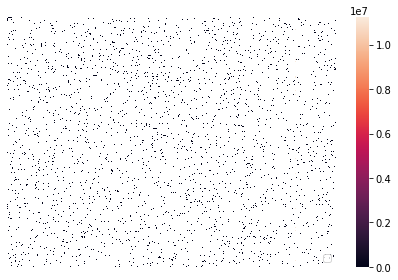

In [10]:
plot = sns.heatmap(df, xticklabels=False, yticklabels=False)
handles, labels = plot.get_legend_handles_labels()
plot.legend(reversed(handles), reversed(labels), title='', loc="lower right")
fig = plot.get_figure()
fig.tight_layout()
fig.savefig(extensionpath + "heatmap.png", dpi=1000, facecolor="white")

In [11]:
def show_audio(comparison):
    distance, leftid, rightid = comparison
    print(distance)

    data, rate = librosa.core.load(audiopath + leftid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

    data, rate = librosa.core.load(audiopath + rightid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

display_count = 10
for i in range(display_count):
    if (i % 2) == 0:
        show_audio(full_distances[i])
        
for i in range(display_count):
    if (i % 2) == 0:
        show_audio(full_distances[i - display_count])

0.0


/usr/local/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


/usr/local/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


0.022013677500676627


0.0340668807267601


0.053142913242881486


0.061546928142822664


11203001.400651466


11203229.92170102


11206511.65603566


11208506.692197617


11223032.652781067
